In [ ]:
import sys
import json
import os
from tqdm import tqdm
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import itertools

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [ ]:
sys.path.insert(0, '..') # Allow relative imports
from scanner.Dataclasses.Response import Response
from scanner.Dataclasses.Request import Request
from scanner.Dataclasses.Endpoint import Endpoint
from scanner.Dataclasses.Interaction import Interaction
from scanner.Utilities.Util import set_config
from scanner.Detection.ClusteringBased.Clustering.DBSCANClustering import DBSCANClustering

# Download data

We use the data provided in:

> Yandrapally, R., Stocco, A., and Mesbah, A. (2020). Near-
duplicate detection in web app model inference. In
ACM/IEEE 42nd international conference on software
engineering, pages 186–197.

Link to the paper: https://dl.acm.org/doi/pdf/10.1145/3377811.3380416

Link to the paper repo: https://github.com/NDStudyICSE2019/NDStudy

Dataset link: https://zenodo.org/record/3385377#.Y3SjkL7MKV4

**Note:** The file is 36.9 GB large

In [ ]:
!wget htps://zenodo.org/record/3385377/files/Crawls_complete.7zt

In [ ]:
!pip install py7zr -q
!pip install zipfile -q

In [ ]:
!py7zr x Crawls_complete.7z

In [ ]:
from zipfile import ZipFile
with ZipFile('./Crawls_complete/GroundTruthModels.zip') as fileobj:
    fileobj.extractall()

# Function declaration

In [ ]:
def load_db_as_dataframe(db_query):
    db_loc = all_crawls_loc + '/gs.db'
    db = sqlite3.connect(db_loc)    
    df = pd.read_sql_query(db_query , db)
    db.close()
    return df

In [ ]:
def load_file(file_location):
    with open(file_location) as f:
        file_content = f.read()
    return file_content

In [ ]:
def load_state_data(scan_path, state_name):
    results_loc = scan_path + '/result.json'
    results_data = load_file(results_loc)
    results_data_json = json.loads(results_data)
    states_data = results_data_json['states']
    return states_data[state_name]

In [ ]:
def load_dom_data(scan_path, state_name):
    dom_data_loc = scan_path + '/doms/' + state_name + '.html'
    dom_data = load_file(dom_data_loc)
    return dom_data

In [ ]:
def calculate_state_hash_ours(state_data, dom_data):
    url = state_data['url']
    created_at = state_data['timeAdded']

    parsed_url = urlparse(url)
    
    # Parse the state as Interaction (from our pipleine) and return its hash
    ep = Endpoint(host=parsed_url.netloc, 
                  path=parsed_url.path, 
                  state_id='', 
                  from_interaction_id='')
    req = Request(endpoint=ep)
    resp = Response(data=dom_data, code=200)
    inter = Interaction(request=req, 
                        response=resp, 
                        state_id='')
    return inter.hash

In [ ]:
def get_state_names(app_crawl_path):
    results_loc = app_crawl_path + '/result.json'
    results_data = load_file(results_loc)
    results_data_json = json.loads(results_data)
    states_data = results_data_json['states']
    state_names = list(states_data.keys())
    return state_names

In [ ]:
def get_state_hash(app_crawl_path, state_name):
    state_data = load_state_data(app_crawl_path, state_name)
    dom_data = load_dom_data(app_crawl_path, state_name)
    state_hash = calculate_state_hash_ours(state_data, dom_data)
    return state_hash

In [ ]:
def get_state_index(clustering_input, state_name):
    idx = 0
    for state in clustering_input:
        if state['name'] == state_name:
            break
        else:
            idx += 1
    return idx

In [ ]:
def find_state_pair_distance(metric_col_name, first_state, secondary_state):
    db_query1 = f"SELECT {metric_col_name} FROM nearduplicates WHERE appname='{app_name}' AND state1='{first_state}' AND state2='{secondary_state}';"
    db_query2 = f"SELECT {metric_col_name} FROM nearduplicates WHERE appname='{app_name}' AND state1='{secondary_state}' AND state2='{first_state}';"
    df = load_db_as_dataframe(db_query1)
    if len(df.index) == 0:
        df = load_db_as_dataframe(db_query2)
    assert len(df.index) == 1, f"There is no state pair {state_pair} in the db"
    state_pair_query = df.iloc[0]
    state_pair_distance = state_pair_query[metric_col_name]
    return state_pair_distance

In [ ]:
def generate_distance_matrix(app_crawl_path, metric_col_name):
    state_names = get_state_names(app_crawl_path)
    pairs_distance_matrix = []
    for first_state in tqdm(state_names):
        current_pair_distance_array = []
        for secondary_state in state_names:
            # Handle the case when the same state is checked (there is no data for this case in the DB, but we need it for the distance matrix)
            if first_state == secondary_state:
                distance = 0 # If we compare a state with itself it will have a distance of 0
            else:
                distance = find_state_pair_distance(metric_col_name, first_state, secondary_state)
            current_pair_distance_array.append(distance)
        pairs_distance_matrix.append(current_pair_distance_array)
    distance_matrix = pd.DataFrame(pairs_distance_matrix, columns=state_names, index=state_names)
    return distance_matrix, state_names

In [ ]:
def run_DBSCAN_on_their_metrics(app_crawl_path, metric_col_name):
    db_query = f"SELECT state1, state2, {metric_col_name} FROM nearduplicates WHERE appname = '{app_name}';"
    df = load_db_as_dataframe(db_query)
    dm, state_names = generate_distance_matrix(app_crawl_path, metric_col_name)
    clustering = DBSCANClustering()
    n_clusters, labels = clustering.cluster(dm, distance_type = "precomputed")    
    
    duplicate_state_pairs = []
    for state_pair in state_pairs:
        first_state_idx = state_names.index(state_pair[0])
        first_state_label = labels[first_state_idx]
    
        second_state_idx = state_names.index(state_pair[1])
        second_state_label = labels[second_state_idx]
    
        if first_state_label == second_state_label:
            duplicate_state_pairs.append(state_pair)
            
    return duplicate_state_pairs

In [ ]:
def create_classified_bool_array(duplicate_state_pairs):
    bool_array = []
    for state_pair in state_pairs:
        if state_pair in duplicate_state_pairs:
            bool_array.append(True)
        else:
            bool_array.append(False)
    return bool_array

# Root dir and conifg definition

In [ ]:
all_crawls_loc = os.getcwd() + '/GroundTruthModels'
config = {'random_seed':42}
set_config(config)

# Single app evaluation example

In [ ]:
app_name = 'addressbook'

In [ ]:
craw_loc = f'/{app_name}/crawl-{app_name}-60min'

In [ ]:
app_crawl_path = all_crawls_loc + craw_loc
print(f'Full path to the app crawl: {app_crawl_path}')

## Create data for our clustering algorithm

The data should be a list of dictionaries, which contain at least a 'hash' key 

In [ ]:
clustering_input = list()
state_names = get_state_names(app_crawl_path)
for state_name in tqdm(state_names):
        state_hash = get_state_hash(app_crawl_path, state_name)
        clustering_input.append({'name': state_name, 'hash': state_hash})

## Run DBSCAN clustering on the data

In [ ]:
from scanner.Detection.ClusteringBased.Clustering.DBSCANClustering import DBSCANClustering
clustering_nativ = DBSCANClustering()
n_clusters_nativ, labels_nativ = clustering_nativ.cluster(clustering_input, distance_type='tlsh', field_for_index='name')
print(f'DBSCAN TLSH Nativ found {n_clusters_nativ} clusters')

In [ ]:
clustering_hash2vec = DBSCANClustering()
n_clusters_hash2vec, labels_hash2vec = clustering_hash2vec.cluster(clustering_input, distance_type='hash2vec', field_for_index='name')
print(f'DBSCAN TLSH Hash2Vec found {n_clusters_hash2vec} clusters')

## Create all state pairs as in the paper

In [ ]:
state_pairs = list(itertools.combinations(get_state_names(app_crawl_path),2))

## Find all of the duplicates using our method

Note: We don't have multiple duplicate classes, but only binary decision i.e. are two states in the same cluster or not.

In [ ]:
our_duplicates_dbscan_tlsh_nativ = []
for state_pair in tqdm(state_pairs):
    first_state_idx = get_state_index(clustering_input, state_pair[0])
    first_state_label = labels_nativ[first_state_idx]
    
    second_state_idx = get_state_index(clustering_input, state_pair[1])
    second_state_label = labels_nativ[second_state_idx]
    
    if first_state_label == second_state_label:
        our_duplicates_dbscan_tlsh_nativ.append(state_pair)

print(f'Duplicates found with our TLSH nativ method: {len(our_duplicates_dbscan_tlsh_nativ)}')

In [ ]:
our_duplicates_dbscan_tlsh_hash2vec = []
for state_pair in tqdm(state_pairs):
    first_state_idx = get_state_index(clustering_input, state_pair[0])
    first_state_label = labels_hash2vec[first_state_idx]
    
    second_state_idx = get_state_index(clustering_input, state_pair[1])
    second_state_label = labels_hash2vec[second_state_idx]
    
    if first_state_label == second_state_label:
        our_duplicates_dbscan_tlsh_hash2vec.append(state_pair)

print(f'Duplicates found with our TLSH Hash2Vec method: {len(our_duplicates_dbscan_tlsh_hash2vec)}')

## Extract all duplicates from the DB (thiers method)

Note: We get all of the state pairs that are labeled 0 or 1 i.e clones or near duplicates

In [ ]:
their_near_duplicate_class_label = 1
their_clone_class_label = 0

searched_class_labels = [their_clone_class_label, their_near_duplicate_class_label]

We query all of the rows that corespond to the app currently being processed

In [ ]:
their_duplicates_gs = []
for state_pair in tqdm(state_pairs):
    first_state = state_pair[0]
    secondary_state = state_pair[1]
    
    db_query1 = f"SELECT HUMAN_CLASSIFICATION FROM nearduplicates WHERE appname='{app_name}' AND state1='{first_state}' AND state2='{secondary_state}';"
    db_query2 = f"SELECT HUMAN_CLASSIFICATION FROM nearduplicates WHERE appname='{app_name}' AND state1='{secondary_state}' AND state2='{first_state}';"
    df = load_db_as_dataframe(db_query1)
    if len(df.index) == 0:
        df = load_db_as_dataframe(db_query2)
        
    assert len(df.index) == 1, f"There is no state pair {state_pair} in the db"
    state_pair_query = df.iloc[0]
    
    if state_pair_query['HUMAN_CLASSIFICATION'] in searched_class_labels:
        their_duplicates_gs.append(state_pair)

In [ ]:
print(f'Duplicates classfied by their people: {len(their_duplicates_gs)}')

## Mixed approach

Now let's try to run DBSCAN using the distance metricsprovided in their database.
For this case we're gonna use the precomputed distance option for cluster calculation, because we only have the pairwise distance between all states.

## Evaluate the app on all metrics

In [ ]:
metric_col_names = ["DOM_RTED", "DOM_Levenshtein", "DOM_contentHash", "DOM_SIMHASH", "VISUAL_BlockHash", "VISUAL_PHash", "VISUAL_Hyst", "VISUAL_PDiff", "VISUAL_SIFT", "VISUAL_SSIM"]

In [ ]:
results = pd.DataFrame()
results['state1'] = [i[0] for i in state_pairs]
results['state2'] = [i[1] for i in state_pairs]

In [ ]:
for metric_col_name in metric_col_names:
    metric_duplicates = run_DBSCAN_on_their_metrics(app_crawl_path, metric_col_name)
    results[metric_col_name] = create_classified_bool_array(metric_duplicates) 

In [ ]:
results['TLSH_nativ'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_nativ)
results['TLSH_hash2vec'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_hash2vec)
results['Human'] = create_classified_bool_array(their_duplicates_gs)

In [ ]:
results

In [ ]:
results.to_csv(f'out_{app_name}.csv', index=False)

## Calculate metrics

In [ ]:
evaluation = results.drop(['state1','state2'], axis=1).astype(int)

In [ ]:
y_true = evaluation.iloc[:,-1] # Extract the human classified labels

In [ ]:
y_pred_matrix = evaluation.iloc[:,0:len(evaluation.columns)-1] # Extract the classified labels

In [ ]:
eval_results = pd.DataFrame()

for metric in y_pred_matrix.columns:
    y_pred = y_pred_matrix[metric]
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    row = pd.Series({'TP':tp,'TN':tn,'FP':fp,'FN':fn,'Accuracy': accuracy, 'Recall':recall, 'Precision': precision, 'F1':f1},name=metric)
    
    eval_results = eval_results.append(row)

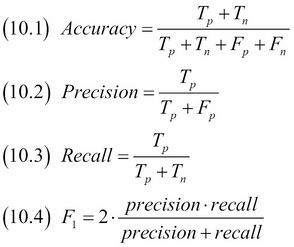

In [ ]:
eval_results

# Run the evaluation on all app data

In [ ]:
app_names = load_db_as_dataframe('SELECT name from apps').iloc[:,0].tolist()

In [ ]:
metric_col_names = ["DOM_RTED", "DOM_Levenshtein", "DOM_contentHash", "DOM_SIMHASH", "VISUAL_BlockHash", "VISUAL_PHash", "VISUAL_Hyst", "VISUAL_PDiff", "VISUAL_SIFT", "VISUAL_SSIM"]

In [ ]:
output_dir = 'app evaluation data'

In [ ]:
from scanner.Detection.ClusteringBased.Clustering.DBSCANClustering import DBSCANClustering
clustering_nativ = DBSCANClustering()
clustering_hash2vec = DBSCANClustering()

for app_name in app_names:
    print(f'Evaluating app: {app_name}')
    crawl_path = f'/{app_name}/crawl-{app_name}-60min'
    app_crawl_path = all_crawls_loc + crawl_path
    
    state_pairs = list(itertools.combinations(get_state_names(app_crawl_path),2))
    
    clustering_input = list()
    state_names = get_state_names(app_crawl_path)
    for state_name in tqdm(state_names):
        state_hash = get_state_hash(app_crawl_path, state_name)
        clustering_input.append({'name': state_name, 'hash': state_hash})
        
    n_clusters_nativ, labels_nativ = clustering_nativ.cluster(clustering_input, distance_type='tlsh', field_for_index='name')
    print(f'DBSCAN TLSH Nativ found {n_clusters_nativ} clusters')
    
    n_clusters_hash2vec, labels_hash2vec = clustering_hash2vec.cluster(clustering_input, distance_type='hash2vec', field_for_index='name')
    print(f'DBSCAN TLSH Hash2Vec found {n_clusters_hash2vec} clusters')
    
    our_duplicates_dbscan_tlsh_nativ = []
    for state_pair in tqdm(state_pairs):
        first_state_idx = get_state_index(clustering_input, state_pair[0])
        first_state_label = labels_nativ[first_state_idx]
        
        second_state_idx = get_state_index(clustering_input, state_pair[1])
        second_state_label = labels_nativ[second_state_idx]
        
        if first_state_label == second_state_label:
            our_duplicates_dbscan_tlsh_nativ.append(state_pair)
            
    our_duplicates_dbscan_tlsh_hash2vec = []
    for state_pair in tqdm(state_pairs):
        first_state_idx = get_state_index(clustering_input, state_pair[0])
        first_state_label = labels_hash2vec[first_state_idx]
        
        second_state_idx = get_state_index(clustering_input, state_pair[1])
        second_state_label = labels_hash2vec[second_state_idx]
        
        if first_state_label == second_state_label:
            our_duplicates_dbscan_tlsh_hash2vec.append(state_pair)
    

    their_near_duplicate_class_label = 1
    their_clone_class_label = 0
    
    searched_class_labels = [their_clone_class_label, their_near_duplicate_class_label]
    
    their_duplicates_gs = []
    for state_pair in tqdm(state_pairs):
        first_state = state_pair[0]
        secondary_state = state_pair[1]
        
        db_query1 = f"SELECT HUMAN_CLASSIFICATION FROM nearduplicates WHERE appname='{app_name}' AND state1='{first_state}' AND state2='{secondary_state}';"
        db_query2 = f"SELECT HUMAN_CLASSIFICATION FROM nearduplicates WHERE appname='{app_name}' AND state1='{secondary_state}' AND state2='{first_state}';"
        df = load_db_as_dataframe(db_query1)
        if len(df.index) == 0:
            df = load_db_as_dataframe(db_query2)
            
        assert len(df.index) == 1, f"There is no state pair {state_pair} in the db"
        state_pair_query = df.iloc[0]
        
        if state_pair_query['HUMAN_CLASSIFICATION'] in searched_class_labels:
            their_duplicates_gs.append(state_pair)
    
    
    results = pd.DataFrame()
    results['state1'] = [i[0] for i in state_pairs]
    results['state2'] = [i[1] for i in state_pairs]
    
    for metric_col_name in metric_col_names:
        metric_duplicates = run_DBSCAN_on_their_metrics(app_crawl_path, metric_col_name)
        results[metric_col_name] = create_classified_bool_array(metric_duplicates) 
    
    results['TLSH_nativ'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_nativ)
    results['TLSH_hash2vec'] = create_classified_bool_array(our_duplicates_dbscan_tlsh_hash2vec)
    results['Human'] = create_classified_bool_array(their_duplicates_gs)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    results.to_csv(f'{output_dir}/out_{app_name}.csv', index=False)
    
    evaluation = results.drop(['state1','state2'], axis=1).astype(int)
    y_true = evaluation.iloc[:,-1] # Extract the human classified labels
    y_pred_matrix = evaluation.iloc[:,0:len(evaluation.columns)-1] # Extract the classified labels
    
    eval_results = pd.DataFrame()

    for metric in y_pred_matrix.columns:
        y_pred = y_pred_matrix[metric]
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        row = pd.Series({'TP':tp,'TN':tn,'FP':fp,'FN':fn,'Accuracy': accuracy, 'Recall':recall, 'Precision': precision, 'F1':f1},name=metric)
        
        eval_results = eval_results.append(row)

print('Done')